In [28]:
import os
import pandas as pd
import matplotlib.pyplot as plt

df_list = []
filename_list = []
for filename in os.listdir("/home/frankwoods/Desktop/lassie/data/processed_data"):
    df = pd.read_csv(f"/home/frankwoods/Desktop/lassie/data/processed_data/{filename}")
    filename_list.append(filename)
    df_list.append(df)
print(filename_list)

['resistance_depth_15.csv', 'resistance_depth_36.csv', 'resistance_depth_50.csv', 'resistance_depth_54.csv', 'resistance_depth_25.csv', 'resistance_depth_69.csv', 'resistance_depth_67.csv', 'resistance_depth_46.csv', 'resistance_depth_1.csv', 'resistance_depth_49.csv', 'resistance_depth_45.csv', 'resistance_depth_4.csv', 'resistance_depth_44.csv', 'resistance_depth_59.csv', 'resistance_depth_64.csv', 'resistance_depth_0.csv', 'resistance_depth_21.csv', 'resistance_depth_71.csv', 'resistance_depth_53.csv', 'resistance_depth_20.csv', 'resistance_depth_75.csv', 'resistance_depth_43.csv', 'resistance_depth_61.csv', 'resistance_depth_40.csv', 'resistance_depth_24.csv', 'resistance_depth_62.csv', 'resistance_depth_65.csv', 'resistance_depth_47.csv', 'resistance_depth_41.csv', 'resistance_depth_13.csv', 'resistance_depth_51.csv', 'resistance_depth_5.csv', 'resistance_depth_2.csv', 'resistance_depth_26.csv', 'resistance_depth_38.csv', 'resistance_depth_63.csv', 'resistance_depth_9.csv', 'resis

In [29]:

def extract_features(df):
    res = df["resistance"]
    dep = df["depth"]
    return pd.DataFrame([{
        "res_mean": res.mean(),
        # "res_max": res.max(),
        # "slope": res.max() / dep.max(),
        "depth_max": dep.max(),
    }])

# shape (n,m) where n is number of df and m is extracted feaetures
representation_list = []
for df in df_list:
    representation_list.append(extract_features(df))
print(f"example: {representation_list[0]}")


example:     res_mean  depth_max
0  21.169391   0.004109


# Visualize Extracted Features Histograms

In [30]:
representation_df  = pd.concat(representation_list, axis=0, ignore_index=True)
# # print(representation_df)
def plot_feature_dist(representation_df):
    for col in representation_df.columns:
        plt.hist(representation_df[col], bins=60, density=True)
        plt.title(f"Extracted Feature {col} Global Histogram")
        plt.show()
# plot_feature_dist(representation_df)

# Scale Features

In [31]:
from sklearn.preprocessing import StandardScaler
import numpy as np

def transform_features(df):
    df = df.copy()  # avoid modifying original
    # Apply cube root to 'slope'
    if "slope" in df.columns: df['slope'] = np.log(df['slope'])
    # if "skew" in df.columns: df["skew"] = df["skew"] ** 1.1
    # if "kurtosis" in df.columns: df["kurtosis"] = np.sqrt(df["kurtosis"]) 
    # Standardize
    scaler = StandardScaler()
    df[df.columns] = scaler.fit_transform(df[df.columns])
    return df

scaled_representations = transform_features(representation_df)
# plot_feature_dist(scaled_representations)


# Analyze Correlation Matrix

In [32]:
corr_matrix = scaled_representations.corr()
print(corr_matrix)

           res_mean  depth_max
res_mean   1.000000  -0.773513
depth_max -0.773513   1.000000


## K-Means Clustering Implementation w/ k-means++ init for centroids

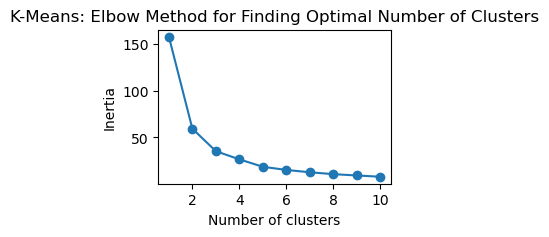

In [33]:
from sklearn.cluster import KMeans
import numpy as np

inertias = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++", n_init=100).fit(scaled_representations)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(3,2))
plt.plot(range(1,11), inertias, marker='o')
plt.title("K-Means: Elbow Method for Finding Optimal Number of Clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.grid=True
plt.show()

# Visualization Functions

In [34]:
from sklearn.decomposition import PCA

def visualize_clusters(representation_list, y_labels, graph_title="", use_pca=False, two_d=False, overlay_plot=False, cluster_i_overlay=False):
    if use_pca:
        pca = PCA(n_components=2) # reduce data down to 2 dims
        X_pca = pca.fit_transform(representation_list) # learns directions of max vairance, projects onto 2D
        # print(y_labels)
        plt.figure(figsize=(3,2))
        plt.title(f"{graph_title} Clustering Visualized with pca")

        # x_pca: x_dim, x_pca: y_dim, c: color points based on clusters, cmap: color map
        # X_pca[:,0] -> 0th index of every row, X_pca[:,1] -> 1st index of every row
        label_color_map = {
            0: 'red',
            1: 'grey',
            2: 'blue',
            3: "green",
            4: "purple",
            5: "pink",
            6: "brown",
        }
        colors = [label_color_map[label] for label in y_labels]
        plt.scatter(X_pca[:,0], X_pca[:,1], c=colors)
        # plt.scatter(X_pca[:,0], X_pca[:,1], c=y_labels, cmap='coolwarm')
        plt.show()
        
    if overlay_plot:
        a = 0.3
        plt.figure(figsize=(3,2))
        for i in range(len(y_labels)):
            y = y_labels[i]
            df = df_list[i]
            if y == 0:
                plt.plot(df["depth"], df["resistance"], color="red", alpha=a)
            elif y == 1:
                plt.plot(df["depth"], df["resistance"], color="grey", alpha=a)
            elif y == 2:
                plt.plot(df["depth"], df["resistance"], color="blue", alpha=a)
            elif y == 3:
                plt.plot(df["depth"], df["resistance"], color="green", alpha=a)
            elif y == 4:
                plt.plot(df["depth"], df["resistance"], color="purple", alpha=a)
            elif y == 5:
                plt.plot(df["depth"], df["resistance"], color="pink", alpha=a)
            elif y == 6:
                plt.plot(df["depth"], df["resistance"], color="brown", alpha=a)
        plt.xlabel('Depth (m)')
        plt.ylabel('Resistance (N)')
        plt.title('Depth vs Resistance Curves')
        plt.show()

    if cluster_i_overlay:
        combined_columns = pd.concat(df_list, axis=0, ignore_index=True)
        a = 0.3
        color_list = ["Red", "Grey", "Blue", "Green", "Purple", "Pink", "Brown"]
        for i in range(max(y_labels)+1): # for each cluster
            plt.figure(figsize=(3,2))
            plt.xlabel('Depth (m)')
            plt.ylabel('Resistance (N)')
            plt.xlim([0, combined_columns["depth"].max()])
            plt.ylim([0, combined_columns["resistance"].max()])
            plt.title(f'{color_list[i]} Cluster: Depth vs Resistance Curves')
            for j in range(len(y_labels)): # for each curve
                if i == y_labels[j]: # if the curve is in cluster
                    plt.plot(df_list[j]["depth"], df_list[j]["resistance"], color=color_list[i], alpha=a)
            plt.show()

    if two_d and len(representation_list.columns) == 2:
        x = representation_list.columns[0]
        y = representation_list.columns[1]
        plt.scatter(representation_list[x], representation_list[y], c=y_labels, cmap="coolwarm")
        plt.title(f"{graph_title} Clustering: {x} and {y}")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()


# K-Means Clustering
- assumes
    - spherical clusters (isotropic)
    - similar size clusters (equal variance)
    - features are on same scale
    - clusters are linearly separable
    - number of clusters (k) is known

kmeans labels:
[1 2 1 2 2 2 1 2 2 2 0 1 1 2 0 1 1 0 2 1 1 0 2 2 1 1 2 0 1 0 0 0 1 2 2 2 1
 1 1 2 2 1 0 2 2 0 1 1 0 2 2 2 0 0 1 1 2 1 2 2 1 2 1 1 2 1 1 2 1 1 0 1 1 1
 1 1 2 0 1]


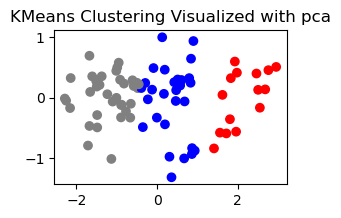

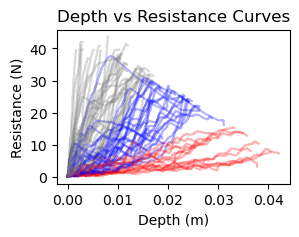

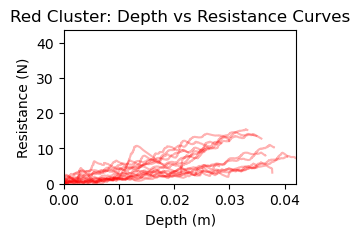

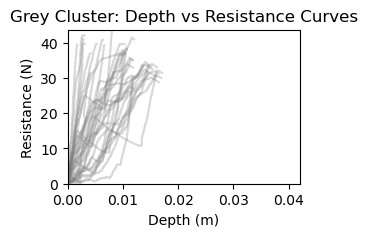

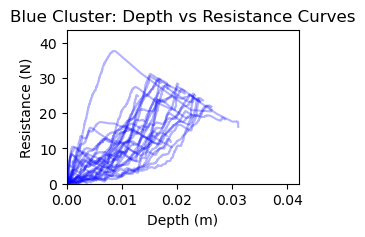

In [35]:
kmeans_elbow = 3
kmeans = KMeans(n_clusters=kmeans_elbow, init="k-means++", n_init=100).fit(scaled_representations)
print(f"kmeans labels:\n{kmeans.labels_}")
visualize_clusters(scaled_representations, kmeans.labels_, graph_title="KMeans", use_pca=True, two_d=False, overlay_plot=True, cluster_i_overlay=True)

# Hierarchical Clustering

[3 0 3 1 1 1 4 1 1 1 2 4 4 1 2 4 4 0 1 3 4 2 0 1 3 3 4 2 3 0 0 2 3 4 1 1 4
 4 4 1 0 3 0 1 1 2 4 4 2 0 1 1 2 2 3 3 1 3 1 0 4 1 4 3 1 4 4 1 4 3 0 3 3 4
 3 4 0 2 4]


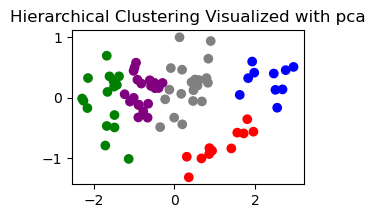

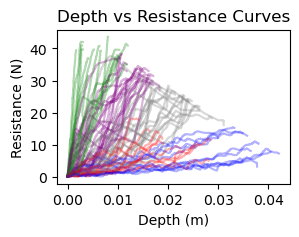

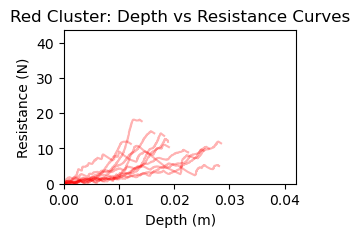

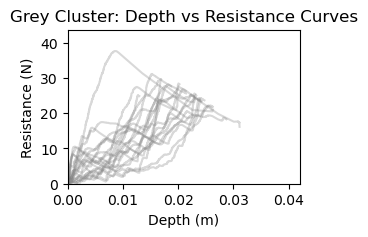

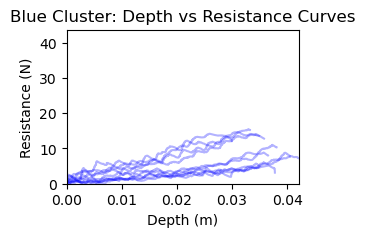

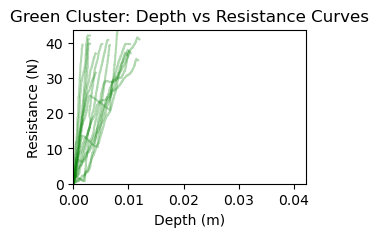

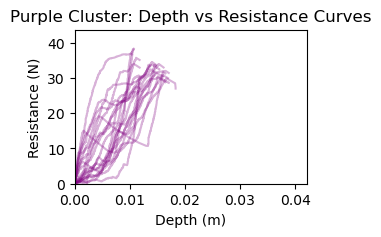

In [36]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

# if distance_threshold != None then n_clusters = None
hierarchical = AgglomerativeClustering(distance_threshold=None, n_clusters=5)
hierarchical.fit(scaled_representations)
linkage = "Ward"
print(hierarchical.labels_)
visualize_clusters(scaled_representations, hierarchical.labels_, graph_title="Hierarchical", use_pca=True, overlay_plot=True, cluster_i_overlay=True)